# Covid 19 Literature Clustering

With the increase in scientific literature, there was a need for those documents to be organised. Using machine learning techniques, I will organise and visualise the scientific literature on or related to COVID-19, so that papers on similar topics are grouped together. This simplifies the navigation of topics and related papers. I plan to use the well-known CORD-19 dataset to carry out this approach.

### Approach

* Clean the body of the papers using NLP.
* Using TDIDF, convert each document into a feature vector.
* Run the resulting sparse matrix through an encoder to obtain data with a lower dimension.
* Apply Clustering on the encoded features
* Evaluate the clustering by reducing the dataset to two dimensions and visualising it with tSNE.
* Finally, use topic modelling to identify keywords for each cluster.

Importing necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import pickle

from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from tensorflow.keras.layers import Dense,Input,ReLU
from tensorflow.keras.models import Model

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering

from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import recall_score, precision_score

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import Pipeline
from spellchecker import SpellChecker



Load the data

In [45]:
path = '../data/'
output_path = '../data/cleaned/'
df = pd.read_csv(path+'data.csv')

## Processing body text

The stopwords below are used in everyday English text and we can easily get them using libraries.However, Research papers will often use words that don't contribute to the meaning and are not considered everyday stopwords, hence I have defined them seperately.

In [12]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

stop_words = stopwords.words('english')
stop_words = stop_words + [i for i in custom_stop_words if i not in stop_words]

In [13]:
def remove_url(text):
    
    re_url = re.compile(
    r'((http://www\.|https://www\.|http://|https://)?' +
    r'[a-z0-9]+([\-.][a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(/.*)?)')
    return re_url.sub('', text)


def remove_html_tags(text):
    """Remove html tags from a string"""
    re_html = re.compile('<.*?>')
    return re.sub(re_html, '', text)

The process of reducing inflected words to their base or root words is known as lemmatization. It ensures that the root word (also known as a lemma) belongs to the language. The POS tag is used in the lemmatization process to determine the correct lemma.

In [14]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


# Next, let's write a function to handle the text data for us.
def preprocess(text):
    
    text = text.lower()
    text = [word for word in text.split() if word not in stop_words and word not in punctuation]
    
    text = ' '.join(text)
    
    text = remove_url(text)
    text = remove_html_tags(text)
    
    # strip double spaces
    text = re.sub(r' +', ' ', text)
    # apparently some of the body text contains this, so I'll remove them.
    text = text.replace('a1111111111', '')
    text = lemmatize_words(text)
    return text

In [10]:
'''
df['processed_body_text'] = df['body_text'].apply(preprocess)
df.drop('body_text',axis=1,inplace=True)
df.to_csv(output_path+'processed_data.csv', index=False)
'''

In [15]:
df = pd.read_csv(output_path+'processed_data.csv')
df = df.dropna().reset_index(drop=True)
df.head()

,paper_id,doi,title,authors,journal,abstract,language,processed_body_text
0,357a9cab01a3d9ba91c444ce43c5994e540e5d11,10.1038/s41467-021-21389-9,Comparison of rhesus and cynomolgus macaques a...,"Salguero, Francisco J.; White, Andrew D.; Slac...",Nat Commun,"A novel coronavirus, SARS-CoV-2, has been iden...",en,"novel coronavirus, sars-cov-2, identified caus..."
1,ce44ae196ace1fa4759367a8dd12bcfe7898bb79,10.1111/ors.12660,Persistent hyposalivation in patients after CO...,"da Mota Santana, Lucas Alves; Sousa‐e‐Silva, N...",Oral Surg,Abstract It was with great interest that we re...,en,persistent hyposalivation patient covid-19 inf...
2,24c1b01ff3b7b7af670908187e18414fec555d0e,10.1101/2020.12.14.20248192,A Comprehensive Clinical Description of Pediat...,"Freeman, Megan Culler; Gaietto, Kristina; DiCi...",medRxiv,OBJECTIVE: We sought to characterize clinical ...,en,"introduction december 2019, severe acute respi..."
3,11eab9687894d34c5dccdaa66f97674fed3d72af,10.1007/s12197-021-09551-x,COVID-19 internet vaccination information and ...,"Goel, Rajeev K.; Nelson, Michael A.",J Econ Finan,This paper examines the impact of internet inf...,en,introduction fight covid-19 pandemic recently ...
4,40549b29f9ffced8dd559842fa8faa2cfb9855a8,10.1371/journal.pone.0253007,Screening for SARS-CoV-2 by RT-PCR: Saliva or ...,"Ibrahimi, Nusaïbah; Delaunay-Moisan, Agnès; Hi...",PLoS One,BACKGROUND: Diagnosis of COVID-19 in symptomat...,en,"introduction propagation infection sars-cov-2,..."


## Vectorization

After the data has been pre-processed, it is time to convert it into a format that our algorithms can comprehend. To accomplish this, we'll use tf-idf. This will convert our string-formatted data into a score determining the relevance of a word to a document in a collection of documents

In [16]:
vect = TfidfVectorizer(max_features=2**14)
X = vect.fit_transform(df['processed_body_text'].values)

## Deep Encoding Sparse Data

A quality clustering result is typically dependent on how well the data is organized. A simple neural network can be useful because of their ability to efficiently learn new ways to represent high-dimensional data/ sparse data.

I will be building an autoencoder which will recreate the input it receives by first generating lower-dimensional  data representation, which will preserve important features of the data. Lastly, we will reconstruct the data back to its original dimensions. This method can help us improve the clustering model's performance and reduce noise in the data.



In [33]:
def encode_sparse(units, activation='relu'):
    
    n = len(units)- 1
    
    inp_ = Input(shape=(units[0],), name='input')
    
    enc = inp_
    
    # creating a encoder
    for i in range (n-1):
        enc = Dense(units[i+1], activation=activation, name=f'encoder_{i}')(enc)

    enc = Dense(units[-1], name=f'encoder_{n-1}') (enc)
    dec = enc
    
    # creating a decoder
    for i in range (n-1,0,-1):
        dec = Dense(units[i], activation=activation, name=f'decoder_{i}') (dec)
    
    dec = Dense(units[0], name='decoder_O') (dec)
    
    model = Model(inputs=inp_, outputs=dec)
    model.summary()
    
    return model

In [34]:
units=[X.toarray().shape[1], 2500, 1200, 400, 100]

autoencoder = encode_sparse(units)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16384)]           0         
_________________________________________________________________
encoder_0 (Dense)            (None, 2500)              40962500  
_________________________________________________________________
encoder_1 (Dense)            (None, 1200)              3001200   
_________________________________________________________________
encoder_2 (Dense)            (None, 400)               480400    
_________________________________________________________________
encoder_3 (Dense)            (None, 100)               40100     
_________________________________________________________________
decoder_3 (Dense)            (None, 400)               40400     
_________________________________________________________________
decoder_2 (Dense)            (None, 1200)              4812

In [35]:
encoded_layer = f'encoder_{(len(units)- 2)}'

# we take the layer that we are interested in
hidden_encoder_layer = autoencoder.get_layer(name=encoded_layer).output

# create just the encoder model that we can use after the autoencoder will be trained
encoder = Model(inputs=autoencoder.input, outputs=hidden_encoder_layer)

In [37]:
'''
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(X.toarray(), X.toarray(), batch_size=256, epochs=64, verbose=1)

X_encoded = encoder.predict(X.toarray())

np.save(output_path+'X_encoded.npy', X_encoded)
'''

Epoch 1/64
61/61 [==============================] - 51s 824ms/step - loss: 5.7724e-05
Epoch 2/64
61/61 [==============================] - 50s 821ms/step - loss: 5.7724e-05
Epoch 3/64
61/61 [==============================] - 50s 823ms/step - loss: 5.7715e-05
Epoch 4/64
61/61 [==============================] - 50s 822ms/step - loss: 5.7690e-05
Epoch 5/64
61/61 [==============================] - 50s 825ms/step - loss: 5.7643e-05
Epoch 6/64
61/61 [==============================] - 50s 825ms/step - loss: 5.7558e-05
Epoch 7/64
61/61 [==============================] - 50s 823ms/step - loss: 5.7426e-05
Epoch 8/64
61/61 [==============================] - 50s 824ms/step - loss: 5.7239e-05
Epoch 9/64
61/61 [==============================] - 50s 825ms/step - loss: 5.7027e-05
Epoch 10/64
61/61 [==============================] - 50s 827ms/step - loss: 5.6830e-05
Epoch 11/64
61/61 [==============================] - 50s 824ms/step - loss: 5.6661e-05
Epoch 12/64
61/61 [==============================] -

In [47]:
X_encoded = np.load(output_path+'X_encoded.npy')
X_encoded.shape

(15600, 100)

## Clustering

#### How many clusters?


The task of organising an unclassified collection of documents into meaningful, homogeneous clusters based on some concept of document similarity. We'll look at the inertia and silhouette score at various k values to identify the ideal k value for k-means.When we plot silhouette against k, there will be a k value where we get the highest score. This is the ideal number of clusters.

In [48]:

km_inertia = []
km_silhouette = []

for num_clusters in tqdm(range(2,25)):
    
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_encoded)
    
    preds = kmeans.predict(X_encoded)

    distance=cdist(X_encoded, kmeans.cluster_centers_)    
    km_inertia.append(np.sum(np.min(distance,axis=1)) / X_encoded.shape[0])
    km_silhouette.append(silhouette_score(X_encoded, preds))

100%|███████████████████████████████████████████| 23/23 [02:10<00:00,  5.65s/it]


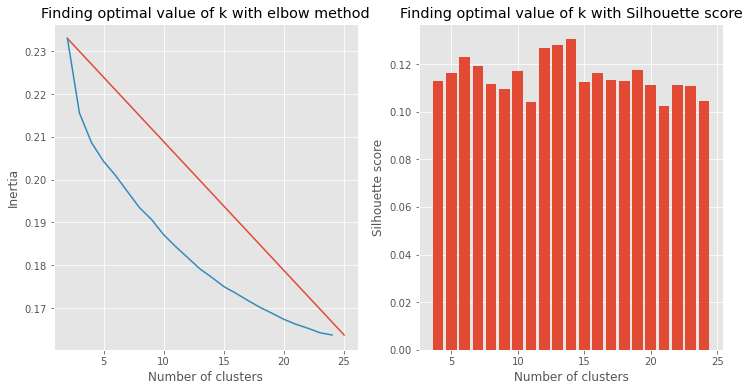

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot([2,25], [km_inertia[0], km_inertia[-1]])
plt.plot(range(2,25), km_inertia)
plt.title('Finding optimal value of k with elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.bar(range(4,25), km_silhouette[2:])
plt.title('Finding optimal value of k with Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')


plt.show()

##### The optimal number of clusters obtained is 14.

In [51]:
total_clusters = 14

## Evaluate the clusters obtained using different techniques using supervised learning techqiues

Now that we've determined an appropriate k value, we can apply various clustering algorithms to the deep-encoded feature vector. Then, using supervised learning, we'll see how well the clustering generalises. If the clustering algorithm was successful in identifying meaningful clusters in the data, it should be possible to train a classifier to predict which cluster a given paper belongs to. To evaluate the generalizability of the clustering algorithm, I will use the Stochastic Gradient Descent classifier.


In [52]:
## define clustering instances
algorithms = dict()

# kmeans
algorithms['Kmeans'] = KMeans(n_clusters=total_clusters, random_state=0)

# spectral clustering
algorithms['SpectralClustering'] = SpectralClustering(n_clusters=total_clusters,
                                                      random_state=0,
                                                      affinity='nearest_neighbors')
#agglomerative clustering
algorithms['AgglomerativeClustering'] = AgglomerativeClustering(n_clusters=total_clusters)

In [54]:
def evaluate_cluster(clf, X_enc, X_vectorize, title=''):
    
    # predicting the clusters for the given algorithm
    labels = clf.fit_predict(X_enc)
    
    # Let's divide the data into train and test sets.    
    X_train, X_test, y_train, y_test = train_test_split(X_vectorize, 
                                                        labels, 
                                                        test_size=0.2,
                                                        random_state=0)
    
    '''Fitting the classifier and getting the predictions'''
    
    # SGD instance
    sgd = SGDClassifier(max_iter=10000, random_state=0)

    # fitting the model
    sgd.fit(X_train, y_train)
    
    # getting the predictions
    y_preds = sgd.predict(X_test)
    
    '''Definining different metrics to evaluate the model.'''
    f1 = f1_score(y_test, y_preds, average='weighted')
    f1 = 100 * np.round(f1,2)
    
    acc = 100 * np.round(accuracy_score(y_test, y_preds),2)
    
    recall = recall_score(y_test, y_preds, average='weighted')
    recall = 100 * np.round(recall,2)
    
    precision = precision_score(y_test, y_preds, average='weighted')
    precision = 100 * np.round(precision,2)

    ##  print the results
    print(f'Evaluation of {title} clustering algorithm on SGD Classifier: ')
    print(f'\n\tAccuracy score: {acc} % \n\tF1 score: {f1} %')
    print(f'\tPrecision: {precision} % \n\tRecall: {recall} %')


    return labels



In [55]:

preds = dict()
for algo in algorithms.keys():
    print()
    preds[algo] = evaluate_cluster(algorithms[algo], X_encoded, X.toarray(), algo)
    print()


Evaluation of Kmeans clustering algorithm on SGD Classifier: 

	Accuracy score: 87.0 % 
	F1 score: 87.0 %
	Precision: 87.0 % 
	Recall: 87.0 %


Evaluation of SpectralClustering clustering algorithm on SGD Classifier: 

	Accuracy score: 87.0 % 
	F1 score: 87.0 %
	Precision: 87.0 % 
	Recall: 87.0 %


Evaluation of AgglomerativeClustering clustering algorithm on SGD Classifier: 

	Accuracy score: 78.0 % 
	F1 score: 78.0 %
	Precision: 79.0 % 
	Recall: 78.0 %



In [57]:
dict(zip(range(14), np.bincount(preds['Kmeans'])))


{0: 576,
 1: 2598,
 2: 940,
 3: 2001,
 4: 910,
 5: 641,
 6: 1048,
 7: 923,
 8: 363,
 9: 340,
 10: 1485,
 11: 476,
 12: 2311,
 13: 988}

On the test dataset, both Kmeans and Spectral clustering appear to generalise well. However, when I looked at the data distribution across different clusters in spectral clustering, I noticed that most of the data was concentrated in a few clusters, whereas Kmeans spreads the data out well. As a result, I'll go with Kmeans.

In [58]:
df['num_cluster'] = preds['Kmeans']

## t-SNE

After assigning a cluster to each data point, the next logical step is to visualise it. But there's a catch. We have 100 columns of data. To visualise it, we'll need to limit the number of columns to no more than three. To accomplish this, we'll use t-SNE.

In [59]:
tsne = TSNE(perplexity=50, random_state=0)
X_2d = tsne.fit_transform(X_encoded)

/Users/fidahussainrao/tensorflow-test/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/fidahussainrao/tensorflow-test/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


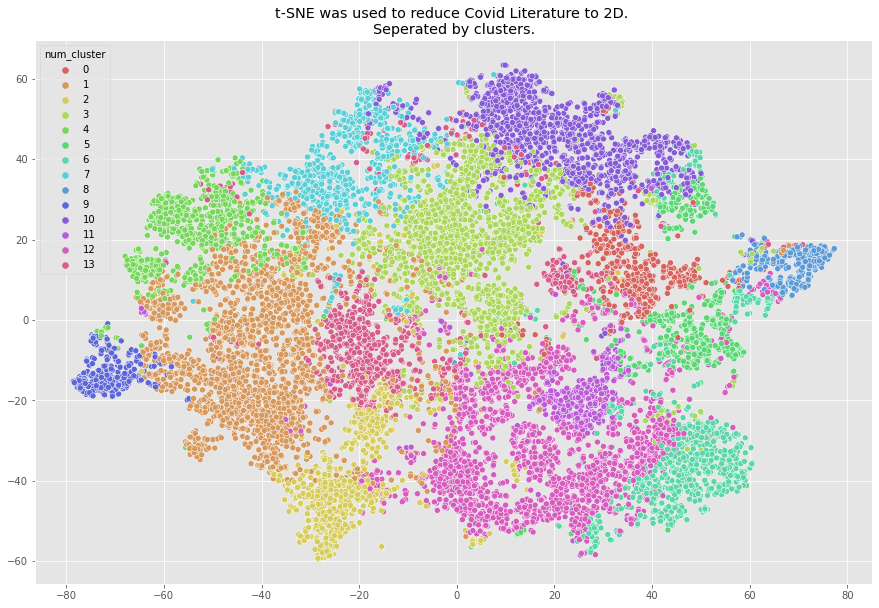

In [60]:
plt.figure(figsize=(15,10))
palette = sns.hls_palette(total_clusters, l=.6, s=.6)

sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['num_cluster'], palette=palette)
plt.title('t-SNE was used to reduce Covid Literature to 2D. \nSeperated by clusters.')
plt.show()

## Topic modelling on each cluster

We'll now try to determine which words in each cluster are the most important. The articles were clustered using K-means, but the themes were not labelled. We will use topic modelling to determine the most important terms for each cluster. 

We will use Non-Negative Matrix Factorization (NMF) for topic modelling.

In [61]:
def top_words(pipeline, top_n=3, num_topics=20):
    '''This function will combine the top three keywords from each of the 20 topics
       and sort them based on their score for a given cluster.'''    
    
    all_words = []
    keywords = dict()

    vectorizer = pipeline[0]
    model = pipeline[1]
    
    for j in range(num_topics):
        a = model.components_[j]
        
        scores=np.flip(np.sort(a)[-top_n:])
        words=[vectorizer.get_feature_names_out()[i] for i in np.flip(np.argsort(a)[-top_n:])]


        for idx, word in enumerate(words):
            if word not in all_words:
                all_words.append(word)
                keywords[word] = scores[np.where(np.array(words)==word)[0][0]]

    d = list({k: v for k, v in sorted(keywords.items(), key=lambda item: item[1])}.keys())
    d.reverse()
    
    ## remove misspelled words
    spell = SpellChecker()
    d = spell.known(d)

    return list(d)

In [62]:
def get_keywords_nmf(cluster_num, num_topic=20):
    
    data = df[df['num_cluster'] == cluster_num]['processed_body_text']
    
    pipeline = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8, min_df=7, smooth_idf=False, 
                    token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')),                         
                     ('nmf', NMF(n_components=20, max_iter=1000,
                                                       init='nndsvd', random_state=0))])
    pipeline.fit(data)

    keywords = top_words(pipeline, top_n=3, num_topics=num_topic)
    
    return keywords

In [63]:


nmf_keywords = []

for i in tqdm(range(total_clusters)):
    nmf_keywords.append(get_keywords_nmf(i))
   

100%|███████████████████████████████████████████| 14/14 [01:11<00:00,  5.09s/it]


In [64]:
print(f'Top 10 keywords for cluster# {total_clusters-3+1} ')
nmf_keywords[-3][:10]


Top 10 keywords for cluster# 12 


['protein',
 'patient',
 'water',
 'specie',
 'wastewater',
 'bat',
 'detection',
 'air',
 'virus',
 'antibody']

## Export the final dataframe

Combine the tSNE-created features and the NMF-provided keywords with the original dataframe. Finally, save the dataframe that has been created. This dataframe will be used to create an interactive dashboard in streamlit.

In [65]:
## appending the 2d features created by tSNE to the original dataframe
df[['tSNE1', 'tSNE2']] = X_2d

In [66]:
## add the keywords to their respective clusters.
d = dict()
for i, words in enumerate(nmf_keywords):
    d[i] = words

In [67]:
df['keywords'] = df['num_cluster'].map(d)

In [68]:
df.head()

,paper_id,doi,title,authors,journal,abstract,language,processed_body_text,num_cluster,tSNE1,tSNE2,keywords
0,357a9cab01a3d9ba91c444ce43c5994e540e5d11,10.1038/s41467-021-21389-9,Comparison of rhesus and cynomolgus macaques a...,"Salguero, Francisco J.; White, Andrew D.; Slac...",Nat Commun,"A novel coronavirus, SARS-CoV-2, has been iden...",en,"novel coronavirus, sars-cov-2, identified caus...",6,40.470142,-6.574870,"[gut, analysis, patient, adjuvant, immunizatio..."
1,ce44ae196ace1fa4759367a8dd12bcfe7898bb79,10.1111/ors.12660,Persistent hyposalivation in patients after CO...,"da Mota Santana, Lucas Alves; Sousa‐e‐Silva, N...",Oral Surg,Abstract It was with great interest that we re...,en,persistent hyposalivation patient covid-19 inf...,10,22.944283,36.615738,"[anticoagulation, score, neurological, fever, ..."
2,24c1b01ff3b7b7af670908187e18414fec555d0e,10.1101/2020.12.14.20248192,A Comprehensive Clinical Description of Pediat...,"Freeman, Megan Culler; Gaietto, Kristina; DiCi...",medRxiv,OBJECTIVE: We sought to characterize clinical ...,en,"introduction december 2019, severe acute respi...",3,26.279726,23.438263,"[ards, score, pain, pneumonia, infant, virus, ..."
3,11eab9687894d34c5dccdaa66f97674fed3d72af,10.1007/s12197-021-09551-x,COVID-19 internet vaccination information and ...,"Goel, Rajeev K.; Nelson, Michael A.",J Econ Finan,This paper examines the impact of internet inf...,en,introduction fight covid-19 pandemic recently ...,8,70.272133,15.694479,"[medical, protein, patient, pain, acceptance, ..."
4,40549b29f9ffced8dd559842fa8faa2cfb9855a8,10.1371/journal.pone.0253007,Screening for SARS-CoV-2 by RT-PCR: Saliva or ...,"Ibrahimi, Nusaïbah; Delaunay-Moisan, Agnès; Hi...",PLoS One,BACKGROUND: Diagnosis of COVID-19 in symptomat...,en,"introduction propagation infection sars-cov-2,...",0,35.860302,8.525916,"[rapid, wastewater, variant, genome, pneumonia..."


In [69]:
df.to_csv(output_path+'final_data.csv', index=False)

## Interactive Dashboard

In the preceding steps, cluster labels and a two-dimensional dataset were obtained. Now, we'll use streamlit to generate an interactive plot to view and analyse clustering performance as well as see how data fits together. We'll colour code the papers according to their clusters and plot them according to their position in the tSNE plot.



#####  Link to the Interactive streamlit dashboard

https://share.streamlit.io/raofida75/covid19-literature-clustering/dashboard.py

In [72]:
from IPython.display import Image


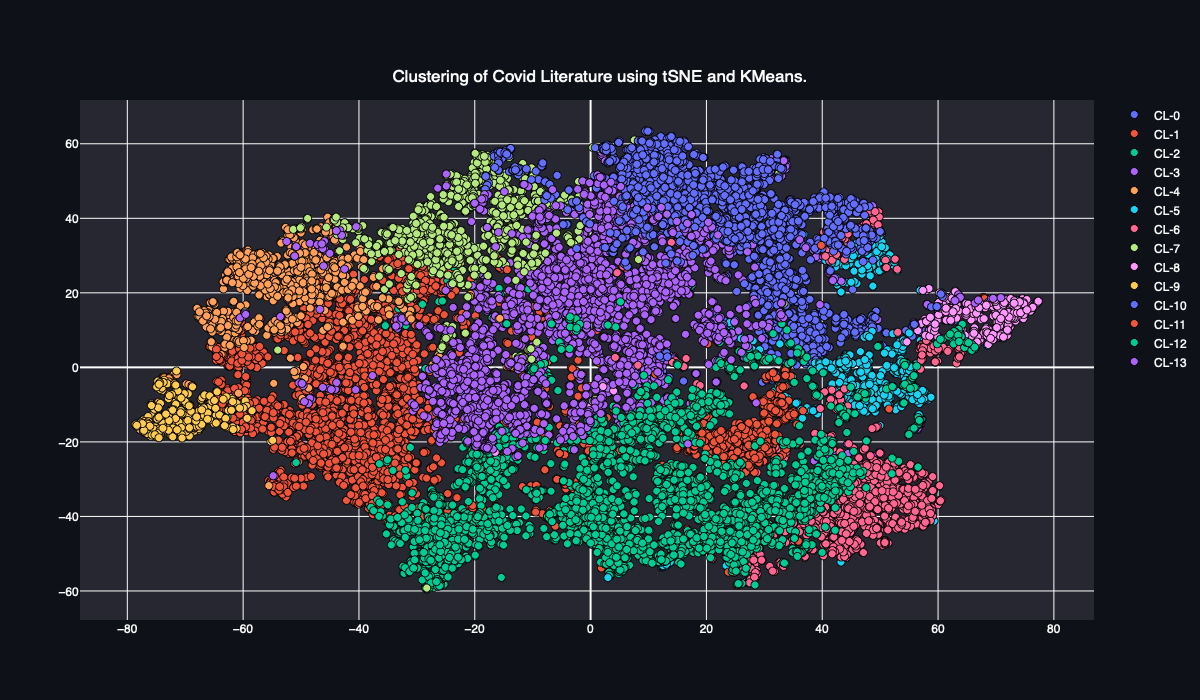

In [73]:
image_path = '../images/'
Image(image_path+'streamlit_plot.png', width = 700, height=500)

Set the slider to the desired cluster number to visualize a specific cluster.

Let's say we want to visualize cluster # 4

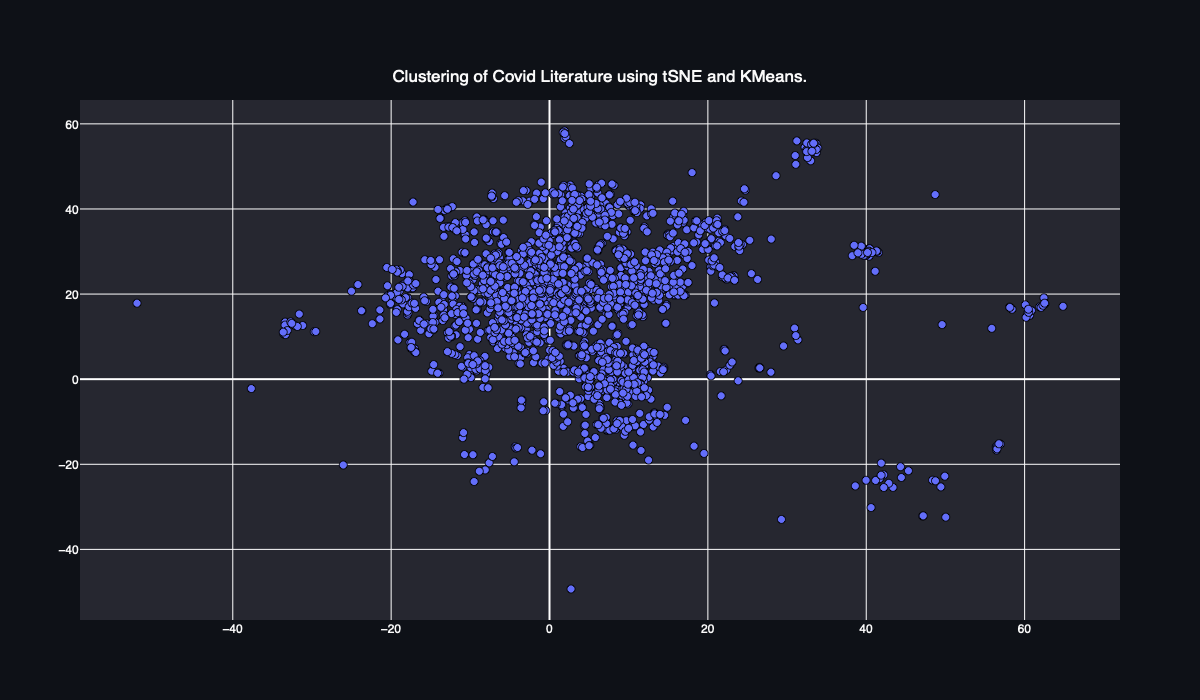

In [83]:
Image(image_path+'cluster_4.png', width=700, height=500)

When a specific cluster is chosen, a list of keywords found in that cluster is displayed alongside the plot.The best way to get a idea about the theme of the cluster is to look at the top keywords for each cluster. Let's visualize the top keywords for cluster # 4, here the theme seem to center around various diseases.



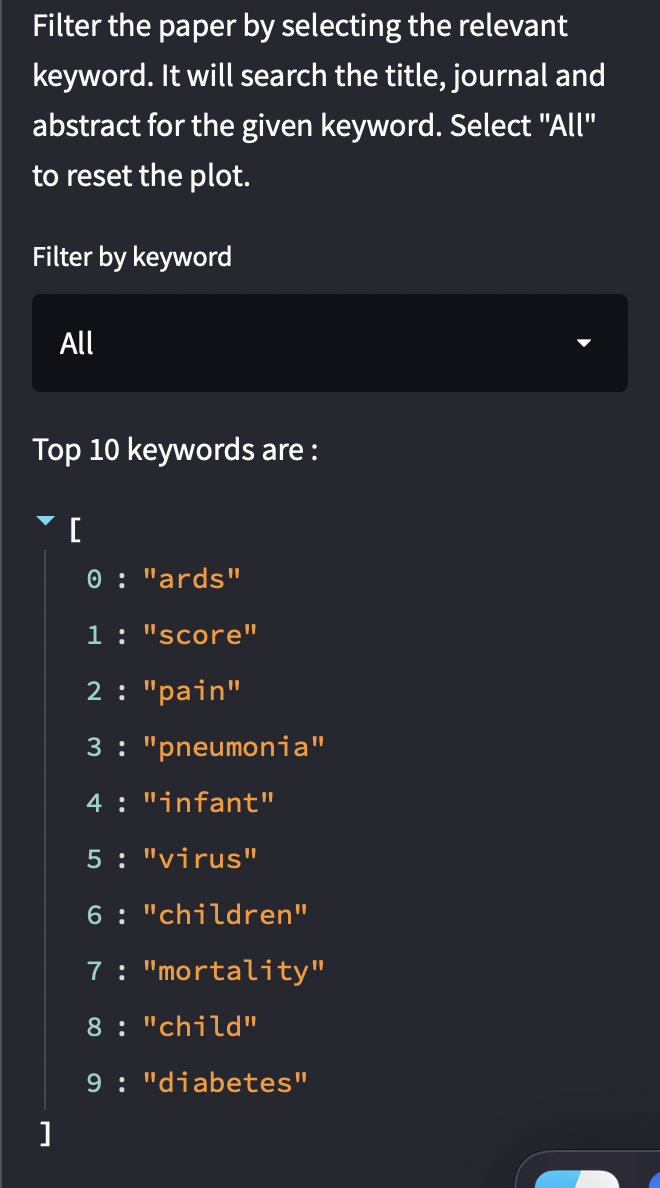

In [82]:
Image(image_path+'select_keywords.png', width= 300, height=250)

 Lets say we are interested in articles which are related to diabetes. We can simply select the relevant keyword from the select box. This is what the plot will look like.

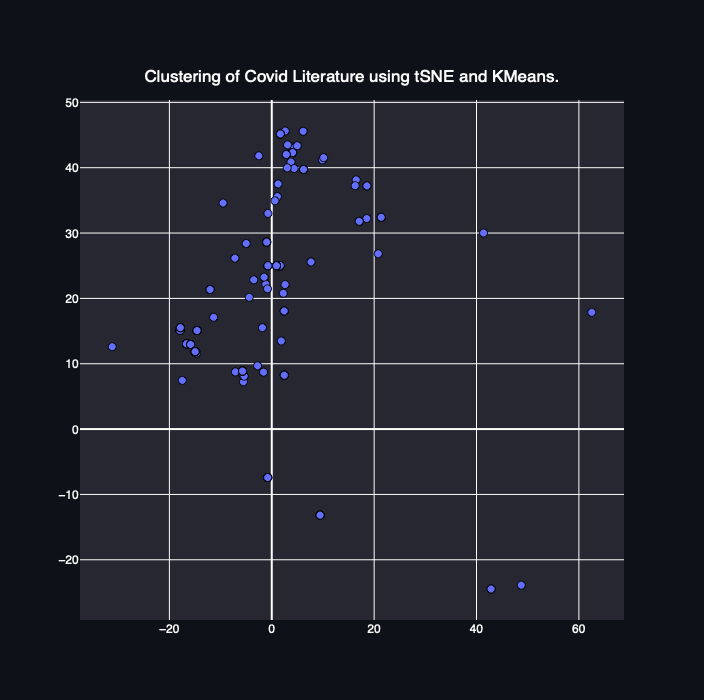

In [77]:
Image(image_path+'cluster_4_diabetes.png', width= 700, height=500)